In [23]:
import numpy as np
import os

## Import the data

In [24]:
del Gammas
for root, dirs, files in os.walk("ellmin3_5_Wmax10_Nmax1000_dGamma100/"):
    for file in files:
        #if file.endswith(".npy"):
        if file.startswith("Seed"):
            number = file[4:-4]
            if 'Seeds' in locals() and 'Gammas' in locals() and 'Ell0s' in locals() and 'Lines' in locals():
                np.append(Seeds,np.load(os.path.join(root, file),allow_pickle=True))
                np.append(Gammas,np.load(os.path.join(root,"Gamma"+number+".npy"),allow_pickle=True))
                np.append(Lines,np.load(os.path.join(root,"Line"+number+".npy"),allow_pickle=True),axis=0)
                np.append(Ell0s,np.load(os.path.join(root,"Ell0"+number+".npy"),allow_pickle=True))
            else:
                Seeds = np.load(os.path.join(root, file),allow_pickle=True)
                Gammas = np.load(os.path.join(root, "Gamma"+number+".npy"),allow_pickle=True)
                Lines = np.load(os.path.join(root, "Line"+number+".npy"),allow_pickle=True)
                Ell0s = np.load(os.path.join(root, "Ell0"+number+".npy"),allow_pickle=True)

In [25]:
Ell0s = np.load('Ell01.npy',allow_pickle=True)
Gammas = np.load('Gamma1.npy',allow_pickle=True)
Lines = np.load('Line1.npy',allow_pickle=True)
Seeds = np.load('Seed1.npy',allow_pickle=True)
print(Ell0s.shape)
for i in range(2,8):
    Ell0s = np.append(Ell0s,np.load('Ell0'+str(i)+'.npy',allow_pickle=True))
    Gammas = np.append(Gammas,np.load('Gamma'+str(i)+'.npy',allow_pickle=True))
    Lines = np.append(Lines,np.load('Line'+str(i)+'.npy',allow_pickle=True),axis=0)
    Seeds = np.append(Seeds,np.load('Seed'+str(i)+'.npy',allow_pickle=True))
print(Ell0s.shape)

(50,)
(350,)


In [26]:
LinesArray = np.zeros((Lines.shape[0],Lines[0].shape[0],Lines[0].shape[1]),dtype= int)
for n,line in enumerate(Lines):
    LinesArray[n] = line
# Remove the value of Bulk
LinesArray[np.where(LinesArray==919)] = 0
# Remove the fiber of width 1
for n,line in enumerate(LinesArray):
    for m,row in enumerate(line):
        if np.array_equal(row,[1,0,0]):
            LinesArray[n,m] = [0,0,1]

## Check that the indexing correspond

In [27]:
import sys
sys.path.append('/home/hcleroy/Extra_Module_py')
import RandomParticleFunctions_v4 as RPF
import Get_High_L_Matrix as GHLM
import MeasurePoisson as MP

In [28]:
N = 40
# Generate a particle with the given seed and measure Ell
Mc,rho0,e1,e2,S = RPF.RandomParticle(Seeds[N])
print(GHLM.MeasureL(Mc,rho0))
# Output the expected value, both should match
print(Ell0s[N])

5.0639477017599726
5.063948014956987


## Compute the fraction of fiber/disk obtained for each line

In [29]:
LinesArray.shape

(350, 100, 3)

In [30]:
# We compute for each Gamma the fraction of fiber and disks
Fraction = np.zeros((LinesArray.shape[1],3),dtype=float)
# We compute the corresponding averagesize
AvSize = np.zeros((LinesArray.shape[1],3),dtype=float)
for n in range(LinesArray.shape[1]):
    Fraction[n] = sum(np.nan_to_num(LinesArray[:,n]/LinesArray[:,n],0))/sum(sum(np.nan_to_num(LinesArray[:,n]/LinesArray[:,n],0)))
    # The masked array helps to ignor the entry for which there is no fiber or no lacunar bulk
    AvSize[n] = np.array([np.mean(np.ma.masked_equal(LinesArray[:,n,0],0)),
                          np.mean(np.ma.masked_equal(LinesArray[:,n,1],0)),
                          np.mean(np.ma.masked_equal(LinesArray[:,n,2],0))])
AvSize = np.nan_to_num(AvSize,0)

<ipython-input-30-53b08f058109>:6: RuntimeWarning: invalid value encountered in true_divide
  Fraction[n] = sum(np.nan_to_num(LinesArray[:,n]/LinesArray[:,n],0))/sum(sum(np.nan_to_num(LinesArray[:,n]/LinesArray[:,n],0)))
<ipython-input-30-53b08f058109>:8: UserWarning: Warning: converting a masked element to nan.
  AvSize[n] = np.array([np.mean(np.ma.masked_equal(LinesArray[:,n,0],0)),


In [31]:
print(Fraction.shape)
print(AvSize.shape)

(100, 3)
(100, 3)


## Compute the Poisson ratio

In [32]:
NUs = list()
for S in Seeds:
    Mc,rho0,e1,e2,S = RPF.RandomParticle(S)
    NUs.append(MP.ComputePoissonRatio(Mc,rho0,Nodes=[0]))
NUs = np.array(NUs)

In [33]:
Seeds = Seeds[NUs.argsort()]
Lines = Lines[NUs.argsort()]
Gammas = Gammas[NUs.argsort()]
Ell0s = Ell0s[NUs.argsort()]
NUs = NUs[NUs.argsort()]
#Fraction = Fraction[NUs.argsort()]

## Make the phase diagram

In [40]:
import matplotlib.pyplot as plt
import formated_matplotlib
import matplotlib.cm as cm
Purple = [86/255.,42/255.,132/255.]
eps=0.005
Gamma = np.linspace(0,1,100)
GammaUp = np.linspace(1+0.5/Gamma.shape[0]+eps,1.2,20)
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

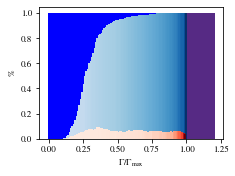

In [42]:
# To make sure the bar overlap correctly
fig,ax = plt.subplots()
ax.bar(Gamma,Fraction[:,1]+Fraction[:,0]+Fraction[:,2],color='black',align='center',width=1/Gamma.shape[0]+eps)#,c=AvSize[:,2])
ax.bar(Gamma,Fraction[:,1]+Fraction[:,0],color=cm.Blues(rescale(AvSize[:,0])),align='center',width=1/Gamma.shape[0]+eps)
ax.bar(Gamma,Fraction[:,1],color=cm.Reds(rescale(AvSize[:,1])),align='center',width=1/Gamma.shape[0]+eps)
ax.bar(GammaUp,np.array([1 for i in range(20)]),color=Purple,width=1/Gamma.shape[0]+eps)
ax.set_xlabel(r'${\Gamma} / {\Gamma_\mathrm{max}}$')
ax.set_ylabel(r'$\%$')
plt.xlim(0,1.2)
plt.ylim(0,1)
plt.savefig('RandomParticleDiagram.pdf',bbox_inches='tight',transparent=True)

In [37]:
FractionWithBulk = np.append(Fraction,np.zeros((20,3),dtype=float),axis=0)

In [39]:
FractionWithBulk.shape

(120, 3)